# Cloudwalk - Risk Analyst Case 41 - Explorative Analysis

## 1. General properties of the data set

In [1]:
# Initial imports and shorthand definitions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from IPython.display import display

%matplotlib inline

# Load the dataset
transactions = pd.read_csv('transactional-sample.csv')

# Print the shape of the dataset (lines, columns)
print('\nData shape: ', transactions.shape)
        
# Count duplicated rows
df = pd.DataFrame(transactions)
bool_series = df.duplicated(keep ='first')
print('\nNumber of duplicated rows: ', sum(bool_series))

# Count the missing values in each column
print('\nMissing Values in each column:')
for col in transactions.columns:
    missing_transactions = transactions[col].isnull().sum()
    if missing_transactions > 0:
        print('\n\t',col, missing_transactions, "{0:.2%}".format(missing_transactions / transactions.shape[0]))

# Count the distinct values in each column
print('\nNumber of unique values in each column:\n')
index = 0
for col in transactions.nunique():
    print('\tColumn', index, ': ', col)
    index += 1


Data shape:  (3199, 8)

Number of duplicated rows:  0

Missing Values in each column:

	 device_id 830 25.95%

Number of unique values in each column:

	Column 0 :  3199
	Column 1 :  1756
	Column 2 :  2704
	Column 3 :  2925
	Column 4 :  3199
	Column 5 :  3124
	Column 6 :  1996
	Column 7 :  2


From this initial analysis, we have established that our data set has no duplicated rows and the only column which has missing items is the one concerning the so called `device_id`.

In addition, the final output indicates that 'Column 0' and 'Column 4' are good candidates for the primary key, since they are composed entirely of unique entries.

To find which candidate is better suited for this role, we must establish the meaning of each column.

In [2]:
# Identify the data types of each column
print('\nColumn data types:\n')
index = 0
for col in transactions.dtypes:
    print('\tColumn', index, ': ', col)
    index += 1
    
# Top rows of the data
transactions.head()


Column data types:

	Column 0 :  int64
	Column 1 :  int64
	Column 2 :  int64
	Column 3 :  object
	Column 4 :  object
	Column 5 :  float64
	Column 6 :  float64
	Column 7 :  bool


,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
0,21320398,29744,97051,434505******9116,2019-12-01T23:16:32.812632,374.56,285475.0,False
1,21320399,92895,2708,444456******4210,2019-12-01T22:45:37.873639,734.87,497105.0,True
2,21320400,47759,14777,425850******7024,2019-12-01T22:22:43.021495,760.36,NaN,False
3,21320401,68657,69758,464296******3991,2019-12-01T21:59:19.797129,2556.13,NaN,True
4,21320402,54075,64367,650487******6116,2019-12-01T21:30:53.347051,55.36,860232.0,False


From the header, we observe that the only numeric columns are `transaction_date` and `transaction_amount`. Furthermore, since the former is the precise time at which the transaction took place, we shall leave it alone for the moment.

In [3]:
# Statistical properties of the transaction_amount
transactions['transaction_amount'].describe()

count    3199.000000
mean      767.812904
std       889.095904
min         1.220000
25%       205.235000
50%       415.940000
75%       981.680000
max      4097.210000
Name: transaction_amount, dtype: float64

The general context of our data is that it pertains to a sample of transactions between merchants (`merchant_id`) and customers (`user_id`). Our goal is to identify which of these transactions are suspicious, that is, which of them are likely to be fraudulent. The meaning of each column is as follows:

- <b>`transaction_id`: Unique identifier of each transaction (our primary key).</b>

- <b>`merchant_id`: Unique identifier of each registered merchant.</b>

- <b>`user_id`: Unique identifier of each registered customer.</b>

- <b>`card_number`: Credit card number used by the customer in the transaction.</b>

- <b>`transaction_date`: Precise time at which the transaction took place.</b>

- <b>`transaction_amount`: Amount charged by the merchant to the customer's card. The currency of the transactions was not specified.</b>

- <b>`device_id`: At this stage, we do not know if this refers to the merchant's point of sale (POS) terminal or if - in the case of online purchases - it refers to the device (computer, mobile phone) used by the customer to carry out the purchase.</b>

- <b>`has_cbk`: Chargeback status of the transaction. That is, if a customer (`user_id`) requested a chargeback on their payment to the issuer of their card. Since we are interested in <u>chargeback fraud</u>, the degree of 'suspicion' of a given transaction will be based on the comparison between purchases of negative chargeback status (-cbk) and positive chargeback status (+cbk).</b>


For the moment, we do not have the means to settle the ambiguity on the `device_id` column, so we keep this information as a reminder for subsequent analysis.

Continuing the broad analysis, we observe from the header of the data set that Column 4 is in the wrong format (it should be set do the `datetime` type).

In [4]:
transactions['transaction_date'] = transactions['transaction_date'].apply(pd.to_datetime, errors='coerce')
transactions['transaction_date'].head()

0   2019-12-01 23:16:32.812632
1   2019-12-01 22:45:37.873639
2   2019-12-01 22:22:43.021495
3   2019-12-01 21:59:19.797129
4   2019-12-01 21:30:53.347051
Name: transaction_date, dtype: datetime64[ns]

## 2. Planning the Analysis

Given our assumption that we are only probing information on <b>chargeback fraud</b>, we expect only transactions with positive chargeback status to be possibly suspicious. Therefore, the degree of suspicion will be measured in how positive chargeback (+cbk) transactions deviate with respect to the statistical behavior of negative chargeback (-cbk) transactions. 

### 2.1. Organizing the data set

Since humans function on a day-to-day basis, it might be useful to organize our data in groups of days and hours of day.

In [5]:
# Setting the data in ascending chronological order
transactions = transactions.sort_values('transaction_date')
transactions.head()

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
3198,21323596,17348,8,650487******9884,2019-11-01 01:27:15.811098,2416.70,NaN,False
3197,21323595,35930,7,544315******7773,2019-11-01 01:29:45.799767,359.68,NaN,False
3196,21323594,57997,84486,522688******9874,2019-11-01 10:23:50.555604,1.55,NaN,False
3195,21323593,9603,59275,528052******3611,2019-11-01 11:47:02.404963,1403.67,NaN,False
3194,21323592,50493,49581,650486******4139,2019-11-01 13:05:34.054967,744.15,NaN,False


In [6]:
# Total time span
timespan = transactions['transaction_date'].iloc[-1] - transactions['transaction_date'].iloc[0]
print('\nTotal time spanned by the data: ', timespan)


Total time spanned by the data:  30 days 21:49:17.001534


In [7]:
# Creating a 'transaction_year_day' column and an 'transaction_hour' column
transactions['transaction_year_month_day'] = transactions['transaction_date'].dt.date
transactions['transaction_hour'] = transactions['transaction_date'].dt.hour
transactions.head()

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk,transaction_year_month_day,transaction_hour
3198,21323596,17348,8,650487******9884,2019-11-01 01:27:15.811098,2416.70,NaN,False,2019-11-01,1
3197,21323595,35930,7,544315******7773,2019-11-01 01:29:45.799767,359.68,NaN,False,2019-11-01,1
3196,21323594,57997,84486,522688******9874,2019-11-01 10:23:50.555604,1.55,NaN,False,2019-11-01,10
3195,21323593,9603,59275,528052******3611,2019-11-01 11:47:02.404963,1403.67,NaN,False,2019-11-01,11
3194,21323592,50493,49581,650486******4139,2019-11-01 13:05:34.054967,744.15,NaN,False,2019-11-01,13


Where we understand the entries of `transaction_hour` by means of an example. That is: `transactions['transaction_hour'] == 1` refers to any transaction that occurs in between `01:00:00.000000` and `01:59:59.999999`, inclusive.

### 2.2. Broad chargeback statistics 

We verify the statistical behavior of the +/-cbk transactions by answering a series of queries.

#### Q1: How many transactions have +/-cbk status? What percentage of transactions have +cbk status?

In [8]:
# Total numbers
transactions['has_cbk'].value_counts()

False    2808
True      391
Name: has_cbk, dtype: int64

In [9]:
# Total number and percentages
pos_cbk_transactions = transactions['has_cbk'].sum()
neg_cbk_transactions = transactions.shape[0] - pos_cbk_transactions 
print('+cbk transactions: ', pos_cbk_transactions, ',', "{0:.2%}".format(pos_cbk_transactions / transactions.shape[0]))
print('-cbk transactions: ', neg_cbk_transactions, ',', "{0:.2%}".format(neg_cbk_transactions / transactions.shape[0]))

+cbk transactions:  391 , 12.22%
-cbk transactions:  2808 , 87.78%


#### Q2: What is the total value (sum over `transaction_amount`) of +/-cbk transactions? What is the statistical distribution?

In [10]:
# Statistical distribution of the transaction amounts of each chargeback status
transactions.loc[:, ['has_cbk', 'transaction_amount']].groupby('has_cbk').describe()

transaction_amount                                                    \
                     count         mean          std   min      25%      50%   
has_cbk                                                                        
False               2808.0   672.324380   797.463853  1.22  191.285  360.315   
True                 391.0  1453.571918  1169.491346  2.89  565.580  999.470   

                             
               75%      max  
has_cbk                      
False     812.5775  4091.83  
True     2140.6800  4097.21

In [11]:
# Total
total_transaction_amount = transactions['transaction_amount'].sum()

# What is the total sum over +/- cbk transaction amounts?
pos_cbk_transaction_amount = transactions.loc[transactions['has_cbk'] == True, :]['transaction_amount'].sum()
neg_cbk_transaction_amount = transactions.loc[transactions['has_cbk'] == False, :]['transaction_amount'].sum()

# Percentages
print('+cbk transactions: ', pos_cbk_transactions, ',', "{0:.2%}".format(pos_cbk_transaction_amount / total_transaction_amount), '%')
print('-cbk transactions: ', neg_cbk_transactions, ',', "{0:.2%}".format(neg_cbk_transaction_amount / total_transaction_amount), '%')

+cbk transactions:  391 , 23.14% %
-cbk transactions:  2808 , 76.86% %


Comparing this to the answer of <b>Q2</b>, we observe that even though +cbk transactions comprise only <b>12.2%</b> of the total transactions, they comprise <b>23.1%</b> of the total value of the transactions.

#### Q3: What is the average transaction amount exchanged per day for +/-cbk transactions?

In [12]:
transaction_daily_amount = transactions.loc[: , ['transaction_year_month_day', 'transaction_amount']].groupby('transaction_year_month_day').sum()
transaction_daily_amount.describe()

,transaction_amount
count,31.000000
mean,79233.338065
std,77326.911743
min,8196.800000
25%,35255.270000
50%,45290.690000
75%,87027.640000
max,294814.060000


In [13]:
transaction_daily_amount['transaction_amount'].head()

transaction_year_month_day
2019-11-01    22094.11
2019-11-02    39147.14
2019-11-03    34223.20
2019-11-04    39893.67
2019-11-05    21567.91
Name: transaction_amount, dtype: float64

<AxesSubplot:xlabel='transaction_year_month_day'>

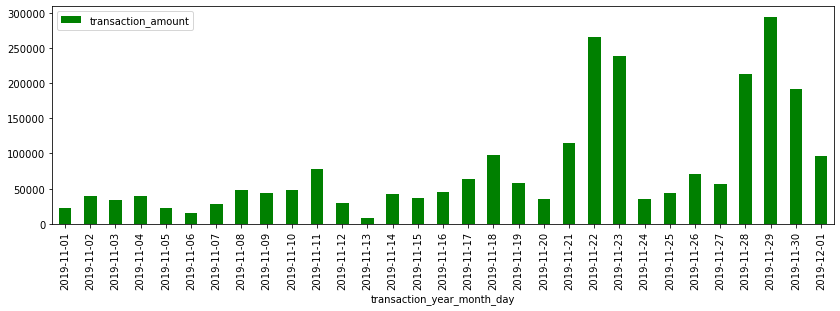

In [14]:
transaction_daily_amount.plot(kind='bar', figsize=(14,4), color = 'green')

We observe two clear behaviors from this graph. First, a repeating pattern with period equal of approximately 7 (the size of a week!). Second, a steep increase by the end of November.

Let us now distinguish between chargeback status.

<AxesSubplot:xlabel='transaction_year_month_day'>

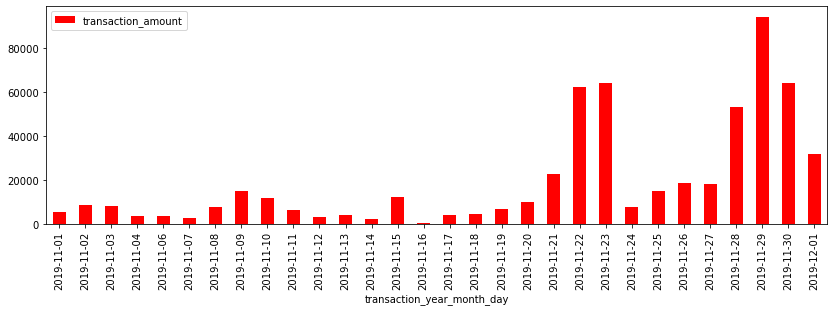

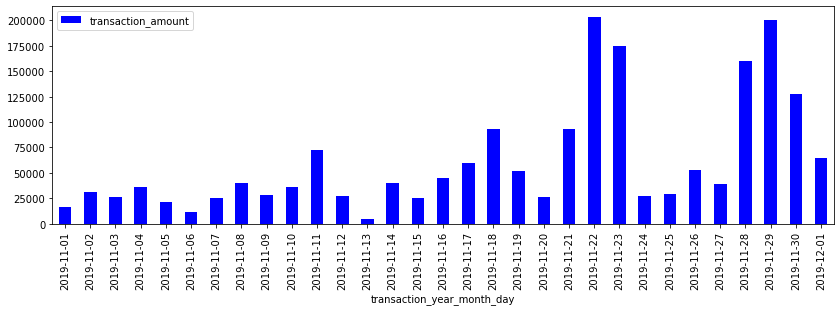

In [15]:
pos_cbk_daily_amount = transactions.loc[transactions['has_cbk'] == True, ['transaction_year_month_day', 'transaction_amount']].groupby('transaction_year_month_day').sum()
neg_cbk_daily_amount = transactions.loc[transactions['has_cbk'] == False, ['transaction_year_month_day', 'transaction_amount']].groupby('transaction_year_month_day').sum()
pos_cbk_daily_amount.plot(kind='bar', figsize=(14,4), color ='red')
neg_cbk_daily_amount.plot(kind='bar', figsize=(14,4), color ='blue')
# Make a better plot

Both have similar tendencies, that is, a cyclic behavior with period of approximately 7 and a spike approximately at the 3rd week (starting at around day 21, inclusive). 

By a quick Google search, we found that the time frame spanning from day <b>2019/11/22</b> to <b>2019/12/01</b> corresponds to the <b>Black Friday</b> event of the respective year. This event is infamous for its discount prices, which might explain the sudden spike in transaction value during this period.

However, spikes in purchases at the end of the month might also be associated with the closing of the card bills of the month, meaning whatever is bought with credit will only be effectively paid at the end of the following month. Unfortunately, since we only have a single month in our data set, we have no further means of probing this hypothesis. We'd need other months to compare.

The above analysis suggests that we should organize the data with two additional categories:

- <b>Weekday (Monday, Tuesday, ...);</b>
- <b>If the transaction occurs during the Black Friday event (True/False)</b>.

In [16]:
# Create a weekday column
transactions['transaction_weekday'] = transactions['transaction_date'].dt.weekday

# Create a day and month column
transactions['transaction_day'] = transactions['transaction_date'].dt.day
transactions['transaction_month'] = transactions['transaction_date'].dt.month

transactions['transaction_day'].head()

3198    1
3197    1
3196    1
3195    1
3194    1
Name: transaction_day, dtype: int64

In [17]:
# Black friday boolean
black_friday = ((transactions['transaction_month'] == 11) & (transactions['transaction_day'] > 20)) | ((transactions['transaction_month'] == 12) & transactions['transaction_day'] == 1)

# Create a boolean column related to the inquiry 'Does the transaction occur in the black friday event of the data set?'
transactions_black_friday = transactions.loc[black_friday, 'transaction_id']
transactions['is_black_friday'] = transactions['transaction_id'].isin(transactions_black_friday)

#### Q4: Based on the answer of Q3, what is the statistical distribution of the transaction amount evaluated per weekday outside the Black Friday event? What about during Black Friday?

<AxesSubplot:xlabel='transaction_year_month_day'>

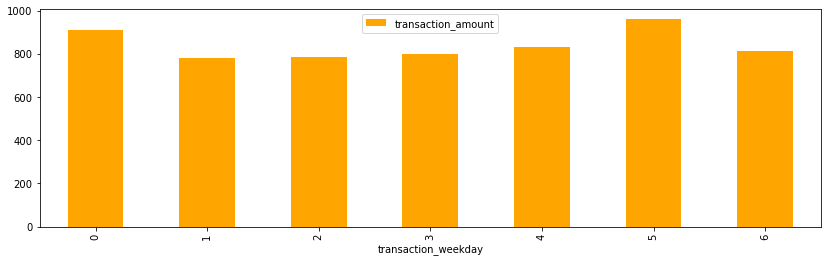

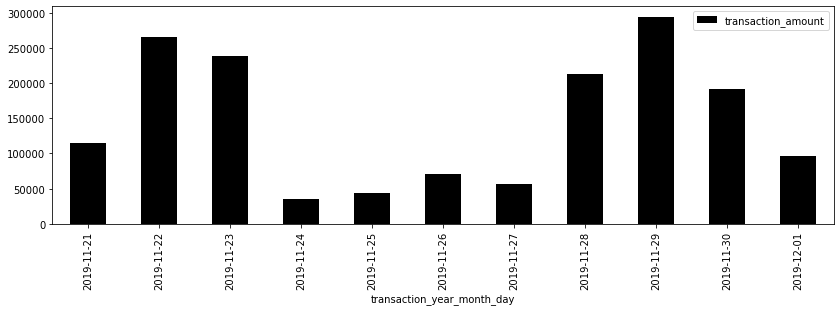

In [18]:
transactions_outside_black_friday = transactions.loc[(transactions['is_black_friday'] == False), ['transaction_weekday', 'transaction_amount']].groupby('transaction_weekday').mean()
transactions_during_black_friday = transactions.loc[(transactions['is_black_friday'] == True), ['transaction_year_month_day', 'transaction_amount']].groupby('transaction_year_month_day').sum()
transactions_outside_black_friday.plot(kind='bar', figsize=(14,4), color = 'orange')
transactions_during_black_friday.plot(kind='bar', figsize=(14,4), color = 'black')

The orange graph relates to the average over each weekday outside of Black Friday. In this graph, we understand that the horizontal axis is the index of each day of the week, starting at <b>0</b> for <b>Monday</b> and ending at <b>6</b> for <b>Sunday</b>. From the data sample, we understand that these averages are made over 3 days each, with exception of Sunday, which is made over 2 days.

The black graph relates to the total transaction amount (y axis) over each day during Black Friday (x axis). Not surprisingly, the peaks in sale value fall precisely on the two Fridays contained within this cut of the data.

#### Q5: Plot the two graphs contained in the answer of Q4 for +/-cbk transactions.

Instead of using the function '.describe()' for every weekday outside Black Friday and every day during Black Friday, we use two box plots.

##### Outside Black Friday

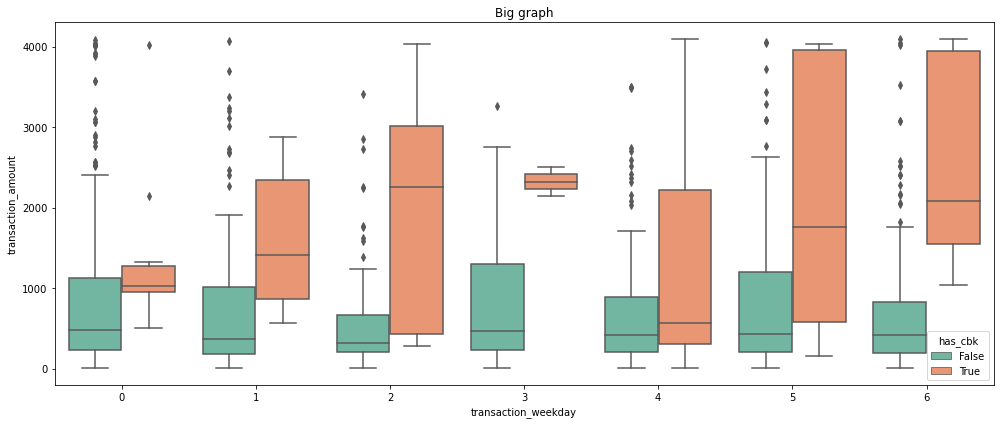

In [136]:
plt.figure(figsize = (14, 6))
plt.title('Big graph')
plt.xlabel('Weekday')
plt.ylabel('Total transaction amount')
ax = sns.boxplot(x = "transaction_weekday", y = "transaction_amount", hue = "has_cbk",
                 data = transactions.loc[(transactions['is_black_friday'] == False), :] , palette="Set2")

##### During Black Friday

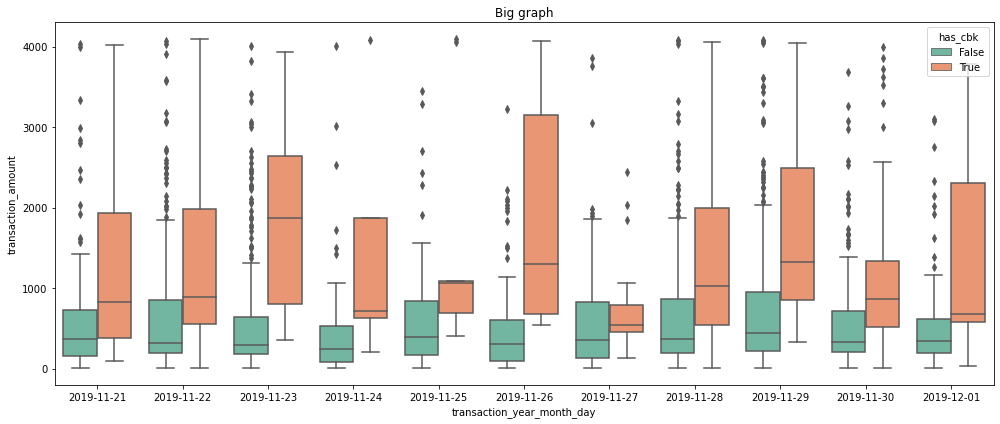

In [134]:
plt.figure(figsize = (14, 6))
plt.title('Big graph')
plt.xlabel('Weekday')
plt.ylabel('Total transaction amount')
ax = sns.boxplot(x = "transaction_year_month_day", y = "transaction_amount", hue = "has_cbk",
                 data = transactions.loc[(transactions['is_black_friday'] == True), :] , palette="Set2")

In general, -cbk transactions tend to be more well behaved. That is, have smaller standard deviation. Note that this might be more due to the fact that there are many more -cbk transactions compared to +cbk transactions. So the statistical character of -cbk transactions is over a larger amount of samples.

#### Q6: How does the percentage of chargebacks change with respect to Black Friday?

##### Number of transactions

In [155]:
print('Total transactions: \n', '\tOutside Black Friday: ', transactions.loc[(transactions['is_black_friday'] == False), ['transaction_id']].shape[0],  ', During Black Friday: ',  transactions.loc[(transactions['is_black_friday'] == True), ['transaction_id']].shape[0])
print('+cbk transactions: \n',  '\tOutside Black Friday: ',  transactions.loc[(transactions['is_black_friday'] == False) & (transactions['has_cbk'] == True), ['transaction_id']].shape[0],', During Black Friday: ' ,transactions.loc[(transactions['is_black_friday'] == True) & (transactions['has_cbk'] == True), ['transaction_id']].shape[0])
print('-cbk transactions: \n',  '\tOutside Black Friday: ', transactions.loc[(transactions['is_black_friday'] == False) & (transactions['has_cbk'] == False), ['transaction_id']].shape[0],', During Black Friday: ',  transactions.loc[(transactions['is_black_friday'] == True) & (transactions['has_cbk'] == False), ['transaction_id']].shape[0])

Total transactions: 
 	Outside Black Friday:  979 , During Black Friday:  2220
+cbk transactions: 
 	Outside Black Friday:  65 , During Black Friday:  326
-cbk transactions: 
 	Outside Black Friday:  914 , During Black Friday:  1894


##### Percentages

In [24]:
# Total in terms of Black Friday
total_n_black_friday = transactions.loc[(transactions['is_black_friday'] == False), ['transaction_id']].shape[0]
total_p_black_friday = transactions.loc[(transactions['is_black_friday'] == True), ['transaction_id']].shape[0]

# Chargebacks in terms of Black Friday
cbk_n_black_friday =  transactions.loc[(transactions['is_black_friday'] == False) & (transactions['has_cbk'] == True), ['transaction_id']].shape[0]
cbk_p_black_friday =  transactions.loc[(transactions['is_black_friday'] == True) & (transactions['has_cbk'] == True), ['transaction_id']].shape[0]

#Percentages
print('+cbk transactions outside BF: ', "{0:.2%}".format(cbk_n_black_friday / total_n_black_friday))
print('+cbk transactions during BF: ', "{0:.2%}".format(cbk_p_black_friday / total_p_black_friday))

+cbk transactions outside BF:  6.64%
+cbk transactions during BF:  14.68%


This means there is an increased percentage of chargebacks during Black Friday.

#### Q7: What is the total `transaction_amount` per hour of day outside the Black Friday event?

<AxesSubplot:xlabel='transaction_hour'>

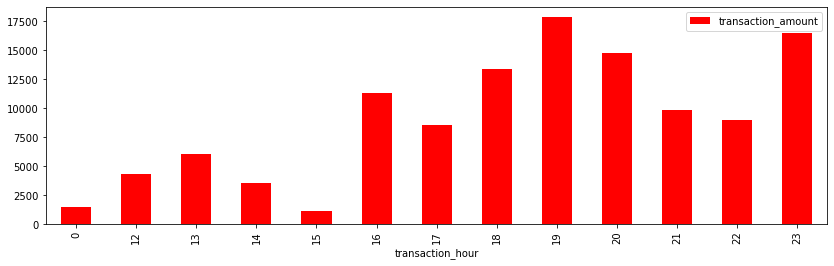

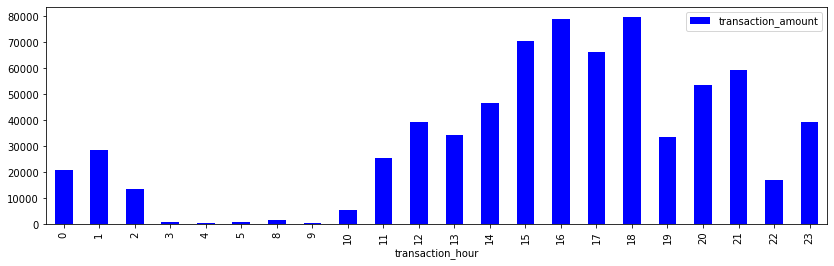

In [25]:
pos_cbk_hourly_amount = transactions.loc[(transactions['has_cbk'] == True) & (transactions['is_black_friday'] == False), ['transaction_hour', 'transaction_amount']].groupby('transaction_hour').sum()
neg_cbk_hourly_amount = transactions.loc[(transactions['has_cbk'] == False) & (transactions['is_black_friday'] == False), ['transaction_hour', 'transaction_amount']].groupby('transaction_hour').sum()
pos_cbk_hourly_amount.plot(kind='bar', figsize=(14,4), color ='red')
neg_cbk_hourly_amount.plot(kind='bar', figsize=(14,4), color ='blue')

#### Q8: What is the average `transaction_amount` per time of day within the Black Friday event?

<AxesSubplot:xlabel='transaction_hour'>

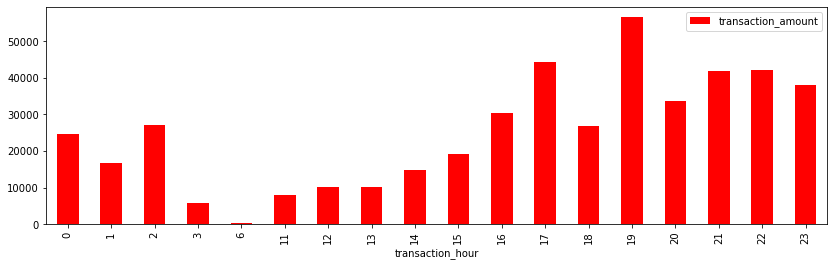

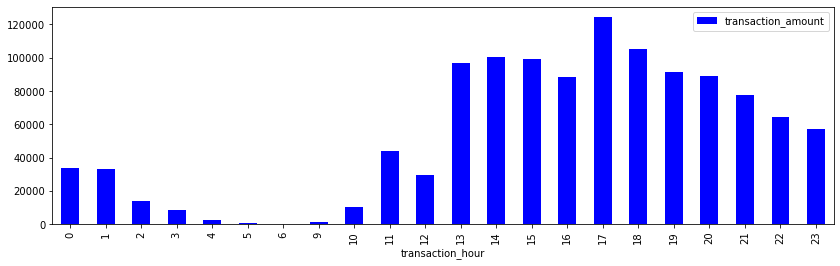

In [26]:
pos_cbk_hourly_amount = transactions.loc[(transactions['has_cbk'] == True) & (transactions['is_black_friday'] == True), ['transaction_hour', 'transaction_amount']].groupby('transaction_hour').sum()
neg_cbk_hourly_amount = transactions.loc[(transactions['has_cbk'] == False) & (transactions['is_black_friday'] == True), ['transaction_hour', 'transaction_amount']].groupby('transaction_hour').sum()
pos_cbk_hourly_amount.plot(kind='bar', figsize = (14,4), color ='red')
neg_cbk_hourly_amount.plot(kind='bar', figsize = (14,4), color ='blue')

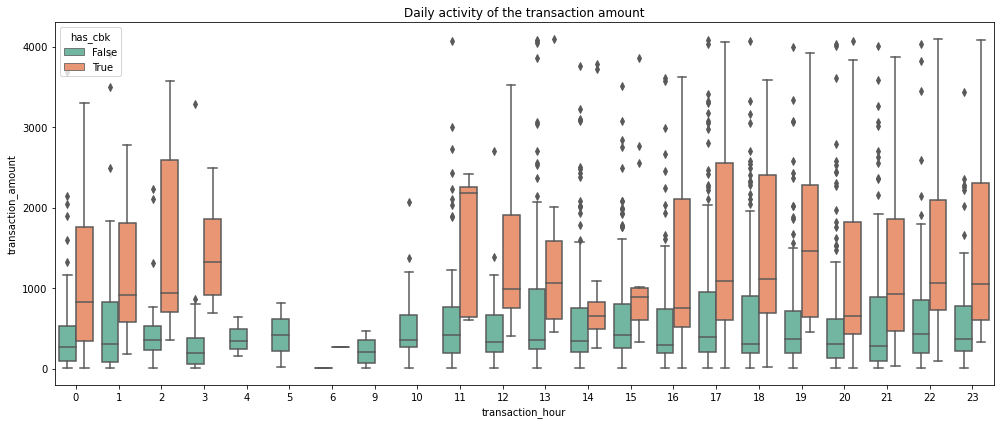

In [160]:
plt.figure(figsize = (14, 6))
plt.title('Daily activity of the transaction amount')
plt.xlabel('Hour of day')
plt.ylabel('Total transaction amount')
ax = sns.boxplot(x = "transaction_hour", y = "transaction_amount", hue = "has_cbk",
                 data = transactions.loc[(transactions['is_black_friday'] == True), :] , palette="Set2")

#### Q8: What is the statistical distribution of the frequency of transactions?

To answer this query, we create a second datetime colum (`transaction_date_1`), shifted by one entry with respect to `transaction_date`. This way, by subtracting the two we can obtain a third column (`transaction_time_delta`) with the time intervals in between transactions.

In [27]:
# Create a transaction_date column where all the elements are shifted by 1
transactions['transaction_date_1'] = transactions['transaction_date']
print(transactions['transaction_date_1'])
transactions['transaction_date_1'] = transactions.transaction_date_1.shift(1)
transactions['transaction_date_1'].iloc[0] = datetime.datetime(2019, 11, 1)
print(transactions['transaction_date_1'])

# Create a column of the time intervals (deltas) between transactions
transactions['transaction_time_delta'] = transactions['transaction_date'] - transactions['transaction_date_1']

# Show statistical distribution of the time deltas
transactions['transaction_time_delta'].describe()

3198   2019-11-01 01:27:15.811098
3197   2019-11-01 01:29:45.799767
3196   2019-11-01 10:23:50.555604
3195   2019-11-01 11:47:02.404963
3194   2019-11-01 13:05:34.054967
                  ...            
4      2019-12-01 21:30:53.347051
3      2019-12-01 21:59:19.797129
2      2019-12-01 22:22:43.021495
1      2019-12-01 22:45:37.873639
0      2019-12-01 23:16:32.812632
Name: transaction_date_1, Length: 3199, dtype: datetime64[ns]
3198   2019-11-01 00:00:00.000000
3197   2019-11-01 01:27:15.811098
3196   2019-11-01 01:29:45.799767
3195   2019-11-01 10:23:50.555604
3194   2019-11-01 11:47:02.404963
                  ...            
4      2019-12-01 21:25:53.374213
3      2019-12-01 21:30:53.347051
2      2019-12-01 21:59:19.797129
1      2019-12-01 22:22:43.021495
0      2019-12-01 22:45:37.873639
Name: transaction_date_1, Length: 3199, dtype: datetime64[ns]


C:\Users\tomat\AppData\Local\Temp\ipykernel_14952\471014079.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['transaction_date_1'].iloc[0] = datetime.datetime(2019, 11, 1)


count                         3199
mean     0 days 00:13:56.446643523
std      0 days 00:51:41.731174351
min         0 days 00:00:00.009406
25%      0 days 00:01:14.265789500
50%         0 days 00:03:35.561798
75%         0 days 00:09:42.795405
max         0 days 19:13:35.945613
Name: transaction_time_delta, dtype: object

<AxesSubplot:>

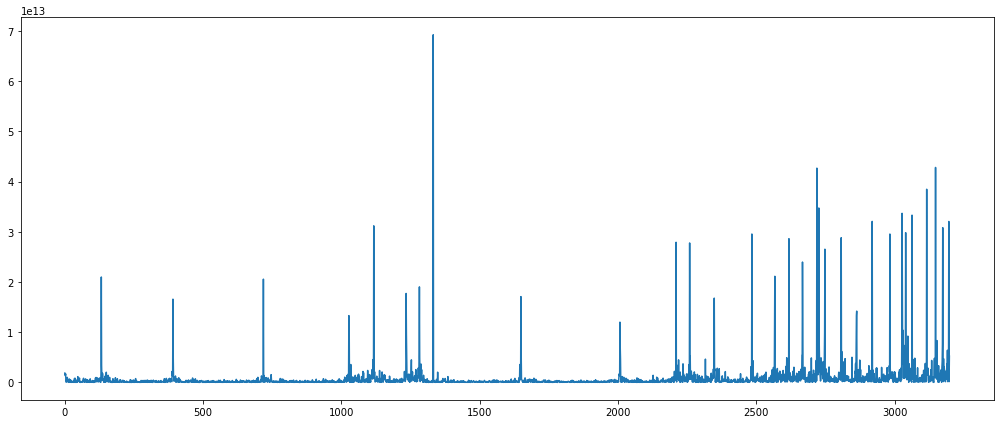

In [74]:
# Plot of the time deltas
transactions['transaction_time_delta'].plot(kind='line' ,figsize=(14,6))

#### Q8: What is the statistical distribution of the `transaction_time_delta`  for +/-cbk transactions?

In [29]:
stat1 = transactions.loc[transactions['has_cbk'] == False, ['transaction_time_delta']].describe()
stat2 = transactions.loc[transactions['has_cbk'] == True, ['transaction_time_delta']].describe()
print(stat1, stat2)

          transaction_time_delta
count                       2808
mean   0 days 00:14:57.008923620
std    0 days 00:54:48.172871611
min       0 days 00:00:00.009406
25%    0 days 00:01:17.072689500
50%    0 days 00:03:41.998324500
75%       0 days 00:10:02.329863
max       0 days 19:13:35.945613           transaction_time_delta
count                        391
mean   0 days 00:06:41.513440166
std    0 days 00:15:24.510000137
min       0 days 00:00:00.087964
25%    0 days 00:00:57.603439500
50%       0 days 00:02:45.638455
75%    0 days 00:07:06.885935500
max       0 days 03:29:02.902800


##### Outside Black Friday

In [30]:
stat1 = transactions.loc[(transactions['has_cbk'] == False) & (transactions['is_black_friday'] == False), ['transaction_time_delta']].describe()
stat2 = transactions.loc[(transactions['has_cbk'] == True) & (transactions['is_black_friday'] == False), ['transaction_time_delta']].describe()
print(stat1, stat2)

          transaction_time_delta
count                        914
mean   0 days 00:30:27.223341137
std    0 days 01:17:31.207422043
min       0 days 00:00:00.233547
25%       0 days 00:03:56.620828
50%       0 days 00:10:36.533782
75%    0 days 00:26:24.128776500
max       0 days 11:53:21.746908           transaction_time_delta
count                         65
mean   0 days 00:14:11.338787523
std    0 days 00:23:22.053105175
min       0 days 00:00:03.834797
25%       0 days 00:01:28.582134
50%       0 days 00:07:20.556535
75%       0 days 00:17:53.583248
max       0 days 02:35:20.333179


##### During Black Friday

In [31]:
stat1 = transactions.loc[(transactions['has_cbk'] == False) & (transactions['is_black_friday'] == True), ['transaction_time_delta']].describe()
stat2 = transactions.loc[(transactions['has_cbk'] == True) & (transactions['is_black_friday'] == True), ['transaction_time_delta']].describe()
print(stat1, stat2)

          transaction_time_delta
count                       1894
mean   0 days 00:07:28.109252231
std    0 days 00:37:11.381869588
min       0 days 00:00:00.009406
25%    0 days 00:00:55.537131750
50%       0 days 00:02:26.314893
75%    0 days 00:05:31.416815750
max       0 days 19:13:35.945613           transaction_time_delta
count                        326
mean   0 days 00:05:11.824337165
std    0 days 00:12:48.129495568
min       0 days 00:00:00.087964
25%    0 days 00:00:49.346732750
50%    0 days 00:02:30.717840500
75%    0 days 00:05:58.476109500
max       0 days 03:29:02.902800


This means that +cbk transactions are, on average, more frequent than -cbk transactions. This might be a sign of chargebacks associated with criminal fraud, that is, if someone gets their hands on a certain customer's card information it'd make sense for them to make as many purchases as possible before the customer notices.

### 2.3. Conclusions

From the above analysis, we have obtained a series of conclusions on the comparison between +cbk and -cbk transactions. That is, compared to -cbk transactions (our measure of honest behavior), +cbk transactions are on average:

- <b>More expensive.</b> +cbk transactions comprise <b>12.2%</b> of the total transactions, yet <b>23.1%</b> of their total value.
- <b>More frequent.</b> The average time between +cbk transactions (<b>6 minutes, 41 seconds</b>) is less than half that of the average time between -cbk transactions (<b>14 minutes, 57 seconds</b>).

This suggests that there might be a correlation between these two quantities and suspicious behavior.

Furthermore, from the daily behavior of the `transaction_amount`, we observed two distinct patterns in the month of November (which comprises most of the data sample):

- <b>2019-11-01 to 2019-11-20:</b> Approximate weekly pattern. This led us to create a column that specifies the day of the week (`transaction_weekday`).

- <b>2019-11-21 to 2019-12-01:</b> A period of time we associated with the <b>Black Friday</b> event. This time section shows, compared to the previous interval, a spike in both `transaction_amount` and percentage of +cbk transactions with respect to the total transactions outside and during <b>Black Friday</b>.

The <u>key</u> (not all) columns introduced in this step of the analysis were the following:

- <b>Categorical:</b> `is_black_friday`

- <b>Numeric:</b> `transaction_year_month_day`, `transaction_weekday`,`transaction_hour`, `transaction_time_delta`

These results give us some ideas on the next steps, which we try to individuate behavior respective to each merchant (`merchant_id`) and each customer (`user_id`). 

## 3. Merchant Analysis

Different merchants sell different goods. This means that the average/total `transaction_amount` exchanged by each merchant (`merchant_id`) might vary significantly from one another. For example, there is little sense in averaging over the sale of electronic hardware and the sale of a hotdog. Furthermore, there are certain types of establishments that are more likely to suffer chargeback fraud based on the re-sale value of their goods (Would you ever buy a ‘used’ candle? What about a used iPhone way below market price?).

Given this motivation, we shall focus on the `transaction_amount` in this section of the analysis. In the following section (<b>User Analysis</b>) we shall probe more deeply into the temporal character of the data.

In [32]:
total_merchants = transactions['merchant_id'].nunique()
print('Total merchants:', total_merchants)

# Merchants that have +cbk transactions
cbk_merchants = transactions.loc[transactions['has_cbk'] == True, 'merchant_id'].drop_duplicates()
print('Merchants with -cbk transactions:', total_merchants - cbk_merchants.nunique(), ', Percentage:', "{0:.2%}".format((total_merchants - cbk_merchants.nunique()) / total_merchants))
print('Merchants with +cbk transactions:', cbk_merchants.nunique(), ', Percentage:', "{0:.2%}".format(cbk_merchants.nunique() / total_merchants))

Total merchants: 1756
Merchants with -cbk transactions: 1638 , Percentage: 93.28%
Merchants with +cbk transactions: 118 , Percentage: 6.72%


Just to add context to this percentage, let us be reminded that +cbk transactions comprise of <b>12.1%</b> the total transactions. This suggests +cbk transactions are more common in certain types of merchants. This alludes to the point we made earlier that some merchants' goods have better re-sale value than those of others and are therefore more likely to be targets of chargeback fraud.

Stating the same information in total quantity and in terms of counts, we have <b>391</b> +cbk transactions distributed among <b>118</b> merchants. What we'd like to learn next is how many -cbk transactions exist within this group of 118 merchants, which we shall refer to as `cbk_merchants`.

### 3.1. Counting the -cbk transactions of `cbk_merchants`

In [33]:
# List of merchants with +cbk transactions
transactions_cbk = transactions.loc[transactions['has_cbk'] == True, 'merchant_id'].drop_duplicates()
print(transactions_cbk)

# Truth column associted with cbk_merchants
merchant_cbk_filter = transactions['merchant_id'].isin(transactions_cbk)

# Transactions of the cbk_merchants
print('\nFor cbk_merchants')
print('Total transactions:', transactions.loc[merchant_cbk_filter, :].shape[0])
print('-cbk transactions:', transactions.loc[merchant_cbk_filter & (transactions['has_cbk'] == False), :].shape[0],',',  "{0:.2%}".format(transactions.loc[merchant_cbk_filter & (transactions['has_cbk'] == False), :].shape[0] / transactions.loc[merchant_cbk_filter, :].shape[0]))
print('+cbk transactions:', transactions.loc[merchant_cbk_filter & (transactions['has_cbk'] == True), :].shape[0],',' , "{0:.2%}".format(transactions.loc[merchant_cbk_filter & (transactions['has_cbk'] == True), :].shape[0] / transactions.loc[merchant_cbk_filter, :].shape[0]))

3185    77570
3180    16266
3165    41354
3142     8942
3110    62052
        ...  
28      11470
26      53816
13      56107
3       68657
1       92895
Name: merchant_id, Length: 118, dtype: int64

For cbk_merchants
Total transactions: 532
-cbk transactions: 141 , 26.50%
+cbk transactions: 391 , 73.50%


This means that, among the 118 merchants that suffer chargeback (`cbk_merchants`), most of their transactions are chargebacks. Furthermore, we have an average of 141 / 118 = <b>1.2</b> -cbk transactions per merchant in this group.

The reason we pointed out this value is because, by the end of this analysis, we want to have clear quantitative criteria or 'tests' to establish what transactions are suspicious. The fact that we only have 1.2 -cbk transactions per merchant in this group means that, for our data set, it would be impractical to create a test based on past history of each single merchant's transactions.

Instead, we will group these merchants in terms of some other quantities, such as <b>percentage of chargebacks</b> (section <b>3.1</b>)  and <b>average transaction amount</b> (section <b>3.2</b>).

### 3.1.`cbk_merchants` grouped in percentage of chargebacks

A piece of information that would be interesting to understand is how much of each merchant's liquid revenue is lost in chargebacks.

In [34]:
# Query of transaction amount of +cbk transactions, organized by merchant
transactions.loc[transactions['has_cbk'] == True, ['merchant_id', 'transaction_amount']].groupby('merchant_id').sum()

,transaction_amount
merchant_id,
1017,10.87
1175,456.48
1308,34517.94
2842,351.63
3109,1847.38
...,...
96692,980.74
97291,7482.51
98272,5803.80


In [35]:
# Query of transaction amount of -cbk transactions, organized by merchant
print(transactions.loc[(transactions['has_cbk'] == False) & merchant_cbk_filter, ['merchant_id', 'transaction_amount']].groupby('merchant_id').sum().shape[0])
transactions.loc[(transactions['has_cbk'] == False) & merchant_cbk_filter, ['merchant_id', 'transaction_amount']].groupby('merchant_id').sum()

52


,transaction_amount
merchant_id,
4153,213.31
4705,1983.40
5404,2688.30
11973,685.92
12745,3759.65
16266,1260.64
17275,4167.47
18267,1972.13
18344,1195.42


A very curious information is presented here. Note how the size of the lists obtained in the previous two queries do not coincide (<b>118</b> for the first and <b>52</b> for the second). Upon inspecting the boolean sentences passed into the `.loc[]` function for each query, we conclude that 118 - 52 = <b>66</b> merchants have <u>only</u> +cbk transactions. In other words, more than half of the `cbk_merchants` have no -cbk transactions.

We proceed with the previous objective of grouping merchants with respect to percentage of +cbk transactions.

In [36]:
# Table of all +cbk transactions of all the merchants that have that have +cbk transactions
cbk_merchants_p = transactions.loc[(transactions['has_cbk'] == True), ['merchant_id', 'transaction_amount']].groupby('merchant_id').sum()

# Table of all -cbk transactions of all the merchants that have +cbk transactions
cbk_merchants_n = transactions.loc[(transactions['has_cbk'] == False) & merchant_cbk_filter,  ['merchant_id', 'transaction_amount']].groupby('merchant_id').sum()

In [164]:
# Defining list of total liquid value of the merchants' transactions
cbk_merchants_t = transactions.loc[merchant_cbk_filter, ['merchant_id','transaction_amount']].groupby('merchant_id').sum()

# Defining percentage of total value of the merchants' +cbk transactions over the total liquid value
perc_cbk_merchants_p = cbk_merchants_p['transaction_amount'] / cbk_merchants_t['transaction_amount']

<AxesSubplot:xlabel='cbk_merchants +cbk transaction value percentage', ylabel='Counts'>

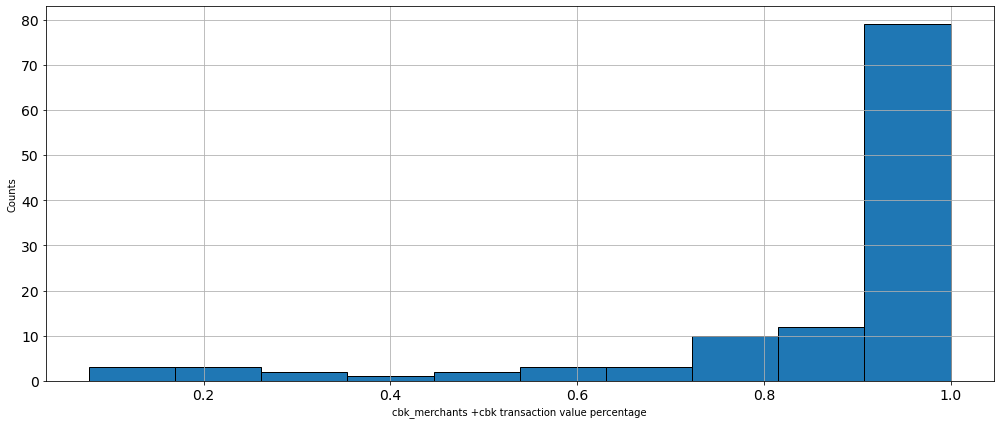

In [165]:
plt.figure(figsize = (14, 6))
plt.xlabel('cbk_merchants +cbk transaction value percentage')
plt.ylabel('Counts')

# Create histogram of the percentages
perc_cbk_merchants_p.hist(xlabelsize = 14, ylabelsize = 14, edgecolor = 'black',bins = 10, figsize = (14,6))

In [194]:
print('Number of cbk_merchants whose +cbk transaction value is larger than 50%:',sum(perc_cbk_merchants_p >= 0.5)) 
print('\nNumber of cbk_merchants whose +cbk transaction value is larger than 90%:', sum(perc_cbk_merchants_p >= 0.9))

Number of cbk_merchants whose +cbk transaction value is larger than 50%: 108

Number of cbk_merchants whose +cbk transaction value is larger than 90%: 80


For most `cbk_merchants` (<b>80</b>), the value of their +cbk transactions exceed <b>90%</b> of the total value of their sales.

### 3.2. `cbk_merchants` grouped in terms of price range

In [40]:
# Calculate the mean transaction value of the merchants 
merchant_p_cbk_transaction_average = transactions.loc[transactions['has_cbk'] == True, ['merchant_id', 'transaction_amount']].groupby('merchant_id').mean()
merchant_n_cbk_transaction_average = transactions.loc[(transactions['has_cbk'] == False) & merchant_cbk_filter, ['merchant_id', 'transaction_amount']].groupby('merchant_id').mean()
print(merchant_n_cbk_transaction_average.describe())
print(merchant_p_cbk_transaction_average.describe())

       transaction_amount
count           52.000000
mean           732.134394
std            919.678523
min              2.230000
25%            104.482000
50%            417.880000
75%            947.965750
max           4036.960000
       transaction_amount
count          118.000000
mean          1537.954006
std           1154.029790
min              2.890000
25%            573.750000
50%           1058.432500
75%           2514.205000
max           4023.150000


The range of prices spans from as low as 2.23 to as high as 4036.96. 

array([[<AxesSubplot:title={'center':'transaction_amount'}>]],
      dtype=object)

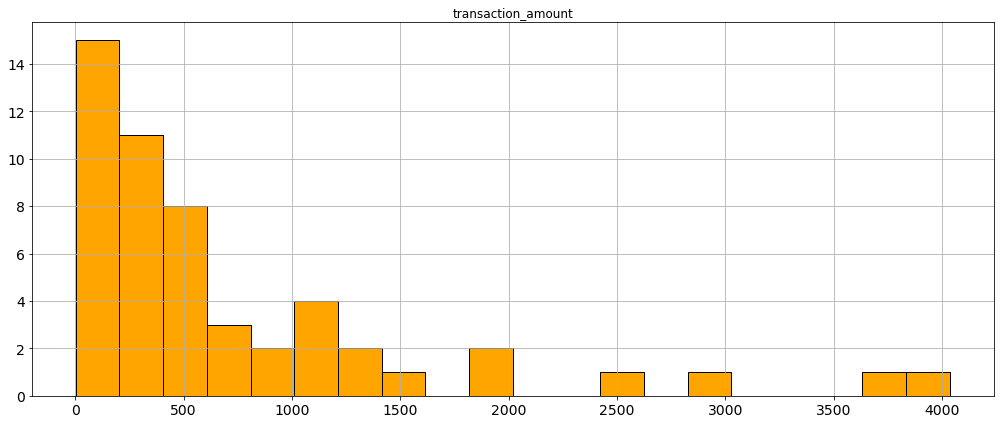

In [167]:
# Create histogram of the percentages
merchant_n_cbk_transaction_average.hist(xlabelsize = 14, ylabelsize = 14, bins = 20, figsize = (14,6),edgecolor = 'black',  color = 'orange')

array([[<AxesSubplot:title={'center':'transaction_amount'}>]],
      dtype=object)

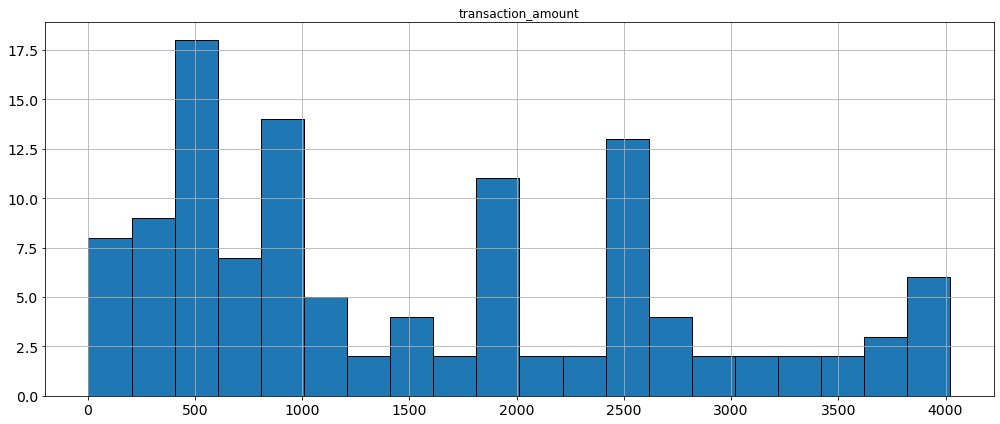

In [166]:
merchant_p_cbk_transaction_average.hist(xlabelsize = 14, ylabelsize = 14, bins = 20, figsize = (14,6),edgecolor = 'black')

array([[<AxesSubplot:title={'center':'transaction_amount'}>,
        <AxesSubplot:title={'center':'transaction_amount'}>]],
      dtype=object)

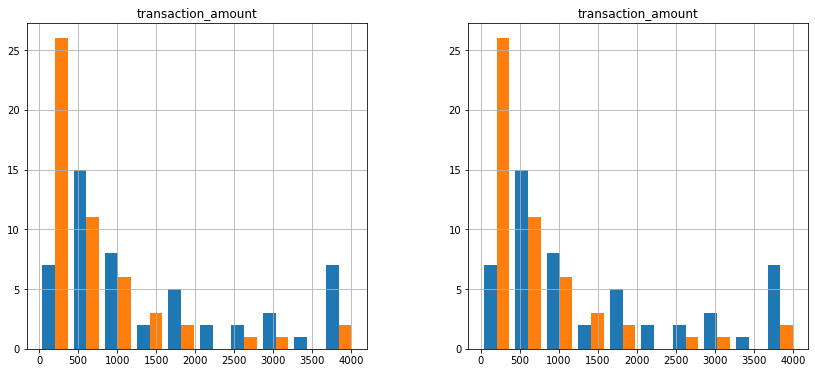

In [43]:
cbk_merchant_forplot = pd.concat([merchant_p_cbk_transaction_average, merchant_n_cbk_transaction_average], axis = 1)
cbk_merchant_forplot.hist(figsize = (14,6))

In the above graphs, orange relates to -cbk transactions and blue to +cbk transactions.

From the graphs, we observe notable spikes in +cbk transactions for the price ranges <b>(400, 600], (800, 1000] ; (1800, 2000] ; (2400, 2600] ; (3800+)</b>.

### 3.3. Conclusions

In this section of the analysis, we have specified the group of merchants that suffered some form of chargeback on their transactions. This group, which we called `cbk_merchants`, is comprised of <b>118</b> merchants. The total transactions associated with these merchants is <b>532</b>. Of these, <b>391</b> (<b>73.5%</b>) are +cbk transactions and <b>141</b> (<b>26.5%</b>) are -cbk transactions. 

Furthermore, the +cbk transactions of <b>108/80/66 (91.5%/67.8%/55.9%) </b> `cbk_merchants` exceed <b>50%/90%/100%</b> of their total value of sales. That is, the few merchants with +cbk transactions are at risk of very high potential losses due to chargeback fraud.

Given the relatively small number of merchants involved in potential chargeback fraud, instead of comparing prior transaction history of each individual merchant, we grouped them in terms of price range. More specifically, in terms of histograms of average transaction amount. We found that the price ranges <b>(400, 600], (800, 1000] ; (1800, 2000] ; (2400, 2600] ; (3800+)</b> were the ones that mostly deviated from the character of the -cbk transactions.

## 4. User Analysis

This part of the analysis is dedicated to the behavior of the <b>2704</b> distinct customers (`user_id`). To make purchases, these customers used a combined total of <b>2925</b> credit cards.

In [47]:
# Number of users with +cbk transactions
user_cbk_counts = transactions.loc[transactions['has_cbk'] == True, ['user_id', 'has_cbk']].groupby('user_id').sum()
print('Statistical distribution of users with +cbk transactions:\n')
print(user_cbk_counts.describe())

Statistical distribution of users with +cbk transactions:

          has_cbk
count  153.000000
mean     2.555556
std      3.122265
min      1.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     25.000000


This means that the <b>391</b> chargebacks were requested by only <b>153</b> customers. Akin to the previous section, we shall denominate this group as `cbk_users`.

In [48]:
cbk_users = transactions.loc[transactions['has_cbk'] == True, ['user_id', 'has_cbk']].drop_duplicates()['user_id']
cbk_users

3185    75889
3180    96495
3165    19820
3142    76819
3135    24027
        ...  
43      10241
34       5541
32      69758
13      81152
1        2708
Name: user_id, Length: 153, dtype: int64

In [49]:
cbk_users_transactions_t = transactions['user_id'].isin(cbk_users).sum()
cbk_users_transactions_p = transactions.loc[transactions['has_cbk'] == True, :].shape[0]
cbk_users_transactions_n = cbk_users_transactions_t - cbk_users_transactions_p
print('cbk_users total transactions: ', cbk_users_transactions_t)
print('cbk_users -cbk transactions: ', cbk_users_transactions_n)
print('cbk_users +cbk transactions: ', cbk_users_transactions_p)

cbk_users total transactions:  455
cbk_users -cbk transactions:  64
cbk_users +cbk transactions:  391


#### Q1. What percentage/number of users have more than 1 +cbk transaction? Calculate the same quantity for `cbk_users`.

In [51]:
# More than 1 +cbk filter
print('Users with more than 1 +cbk transaction: ', sum(user_cbk_counts['has_cbk'] > 1) ,',',"{0:.2%}".format(sum(user_cbk_counts['has_cbk'] > 1) / transactions['user_id'].nunique()))
print('cbk_users with more than 1 +cbk transaction: ', sum(user_cbk_counts['has_cbk'] > 1),',',"{0:.2%}".format(sum(user_cbk_counts['has_cbk'] > 1) / cbk_users.shape[0]))

Users with more than 1 +cbk transaction:  78 , 2.88%
cbk_users with more than 1 +cbk transaction:  78 , 50.98%


This tells us is that less than <b>3%</b> of the customers have previous histories of chargebacks. In addition, for customers that have at least 1 chargeback (`cbk_users`), it is more likely that they have additional chargeback requests than not. 

Therefore, another behavior we should be suspicious of is:

- <b>Customers with more than 1 chargeback request.</b>

In [171]:
# Filter of all cbk_users with more than 1 cbk
cbk_users_1_filter = (user_cbk_counts > 1)
cbk_users_1_filter

,has_cbk
user_id,
900,False
2708,False
3157,False
3584,True
4651,True
...,...
96976,False
97150,False
97611,True


#### Q2. How many users have <u>only</u> +cbk transactions?

In [53]:
# Define the cbk users filter
cbk_users_filter = transactions['user_id'].isin(cbk_users)
cbk_users_n = transactions.loc[cbk_users_filter & (transactions['has_cbk'] == False), :]['user_id'].drop_duplicates()

# Define the cbk users +/-cbk transactions filters
cbk_users_n_filter = cbk_users.isin(cbk_users_n)
cbk_users_p_filter = ~cbk_users_n_filter
cbk_users_p = transactions.loc[cbk_users_filter & cbk_users_p_filter, :]['user_id'].drop_duplicates()

# Print the numbers, percentages
print('Users with only +cbk transactions: ', cbk_users_p.shape[0], ',', "{0:.2%}".format(cbk_users_p.shape[0] / transactions['user_id'].nunique()))
print('cbk_users with only cbk transactions: ', cbk_users_p.shape[0],',', "{0:.2%}".format(cbk_users_p.shape[0] / cbk_users.shape[0]))

Users with only +cbk transactions:  120 , 4.44%
cbk_users with only cbk transactions:  120 , 78.43%


This means that out of the 153 customers, <b>120</b> have only chargeback transactions. These queries give us an idea for suspicious behavior: 

- <b>Customers that have no -cbk transactions</b>.

In [54]:
cbk_users_p_filter

3185     True
3180     True
3165     True
3142     True
3135     True
        ...  
43      False
34       True
32       True
13       True
1       False
Name: user_id, Length: 153, dtype: bool

#### Q3. What is the number/percentage of customers with more than 1 credit card? How does this change for `cbk_users`?

In [181]:
users_extra_cards = transactions.loc[:,['user_id', 'card_number']].groupby('user_id').value_counts() > 1
cbk_users_extra_cards = transactions.loc[cbk_users_filter ,['user_id', 'card_number']].groupby('user_id').value_counts() > 1
print('Users with extra cards: ', sum(users_extra_cards),',',  "{0:.2%}".format(sum(users_extra_cards) / transactions['user_id'].shape[0]))
print('cbk_users with extra cards:', sum(cbk_users_extra_cards) ,',', "{0:.2%}".format(sum(cbk_users_extra_cards) / cbk_users.shape[0]))

Users with extra cards:  167 , 5.22%
cbk_users with extra cards: 75 , 49.02%


What the above result tells us is that customers with chargeback history (`cbk_users`) are more likely to own more than 1 card. The reason for this in the context of chargeback fraud would be to not accumulate chargebacks in the same credit card, as to not alert their credic card company. Then, another suspicious quality to be aware of is:

- <b>Customers that have more than 1 credit card</b>.

### 4.1. Average intervals between user transactions

We shall now study the user temporal behavior with respect to the `is_black_friday` column.

##### Outside Black Friday

In [56]:
# Statistical distribution of -cbk transactions that took place outside of Black Friday, grouped by user
transactions.loc[~cbk_users_filter & (transactions['is_black_friday'] == False), ['user_id', 'transaction_time_delta']].groupby('user_id').mean().describe()

,transaction_time_delta
count,841
mean,0 days 00:30:28.072368002
std,0 days 01:16:14.961277419
min,0 days 00:00:04.620967
25%,0 days 00:04:06.874086
50%,0 days 00:10:50.951282
75%,0 days 00:26:29.624067
max,0 days 11:53:21.746908


In [57]:
# Statistical distribution of +cbk transactions that took place outside of Black Friday, grouped by user
transactions.loc[cbk_users_filter & (transactions['is_black_friday'] == False), ['user_id', 'transaction_time_delta']].groupby('user_id').mean().describe()

,transaction_time_delta
count,38
mean,0 days 00:15:56.744209135
std,0 days 00:17:08.610103688
min,0 days 00:00:45.994820750
25%,0 days 00:06:36.931069375
50%,0 days 00:11:03.783728125
75%,0 days 00:18:21.557754500
max,0 days 01:21:35.828099


##### During Black Friday

In [58]:
# Statistical distribution of -cbk transactions that took place during of Black Friday, grouped by user
transactions.loc[~cbk_users_filter & (transactions['is_black_friday'] == True), ['user_id', 'transaction_time_delta']].groupby('user_id').mean().describe()

,transaction_time_delta
count,1730
mean,0 days 00:07:34.142880260
std,0 days 00:38:41.336706225
min,0 days 00:00:00.009406
25%,0 days 00:00:57.667138250
50%,0 days 00:02:29.234259
75%,0 days 00:05:26.235982
max,0 days 19:13:35.945613


In [59]:
# Statistical distribution of +cbk transactions that took place during of Black Friday, grouped by user
transactions.loc[cbk_users_filter & (transactions['is_black_friday'] == True), ['user_id', 'transaction_time_delta']].groupby('user_id').mean().describe()

,transaction_time_delta
count,126
mean,0 days 00:05:27.811796008
std,0 days 00:08:02.949684759
min,0 days 00:00:00.087964
25%,0 days 00:01:25.235094125
50%,0 days 00:03:00.984044916
75%,0 days 00:05:24.057766312
max,0 days 00:57:48.882803750


Due the distinct behavior of Outside/During Black Friday time frames, deviations from average `transaction_time_delta` should be measured separate from the other.

#### Q4: Outside/During Black Friday, what users have more than 1 transaction?

In [193]:
users_n_bf_transaction_number = transactions.loc[cbk_users_filter & (transactions['is_black_friday'] == False), ['user_id', 'transaction_id']].groupby('user_id').nunique()
print('Users with more than 1 transaction outside BF: ', sum(users_n_bf_transaction_number['transaction_id'] > 1), ',', "{0:.2%}".format(sum(users_n_bf_transaction_number['transaction_id'] > 1) / sum(transactions['is_black_friday'] == False)))
users_bf_transaction_number = transactions.loc[cbk_users_filter & (transactions['is_black_friday'] == True), ['user_id', 'transaction_id']].groupby('user_id').nunique()
print('Users with more than 1 transaction during BF: ', sum(users_bf_transaction_number['transaction_id'] > 1), ',',  "{0:.2%}".format(sum(users_bf_transaction_number['transaction_id'] > 1) / sum(transactions['is_black_friday'] == True)))

Users with more than 1 transaction outside BF:  16 , 1.63%
Users with more than 1 transaction during BF:  75 , 3.38%


### 4.2. Conclusions

By studying the user behavior, we have determined the following qualifiers for suspicious chargeback requests:

- <b>Transactions belonging to customers with more than 1 chargeback request.</b>

- <b>Transactions belonging to customers with no -cbk transactions.</b>

- <b>Transactions belonging to customers with more than 1 credit card.</b>

## 5. Summary of Conclusions

In this explorative analysis, the studied data has the following broad characteristics:

- Spans over the time frame 2019-11-01 to 2019-12-01 (31 days).

- The transactions within this time span has a weekly pattern in the first 20 days, which is broken for transactions that occur over the final 11 days. Upon a Google search, we find that this period of time corresponds to the Black Friday event.

- +cbk transactions comprise 12.2% of the total transactions, yet 23.1% of their total value.

- The average time between +cbk transactions (6 minutes, 41 seconds) is less than half that of the average time between -cbk transactions (14 minutes, 57 seconds).

Analyzing the transactions with respect to merchant behavior, we gathered that:

- All +cbk transactions are contained within 118 establishments (merchants), which comprise 6.72% of the total unique establishments.

- The +cbk transactions of 108/80/66 (91.5%/67.8%/55.9%) `cbk_merchants` exceed 50%/90%/100% of their total value of sales.

- +cbk ransactions within the price ranges (400, 600], (800, 1000] ; (1800, 2000] ; (2400, 2600] ; (3800, ++) deviate significantly from -cbk transactions within the same price ranges.

Analyzing the transactions with respect to merchant behavior, we gathered that:

- 78.4% of customers that have at least one +cbk transaction (`cbk_users`) have no -cbk transactions.

- 51.0% of `cbk_users` have more than 1 +cbk transactions.

- 49.0% of `cbk_users` have more than 1 credit card.

These properties led us to the following qualifiers for suspicious behavior in +cbk transactions:

- <b>Those associated with merchants whose +cbk transactions comprise of more than 50% of the value of their sales.

- <b>Those associated with `transaction_amount` that fall within the price ranges (400, 600], (800, 1000] ; (1800, 2000] ; (2400, 2600] ; (3800, ++).

- <b>Those associated with customers that have no -cbk transactions.

- <b>Those associated with customers that have more than 1 +cbk transactions.

- <b>Those associated with customers that have more than 1 credit card.